### Algorithm 1: Binary Naive Gaussian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.

In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(y | x)$ (also known as **posteriors**).
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(y|x) = \frac{P(x|y)P(y)}{P(x)}
$$

Thus, if we know all these three terms on the right, we can find $P(y \mid x)$

$P(y)$ (also known as **priors**) is simply

$$P(y = 1) = \frac{\Sigma_{i=1}^m 1(y=1)}{m}$$

$$P(y = 0) = \frac{\Sigma_{i=1}^m 1(y=0)}{m}$$

$P(x \mid y)$ (also known as **likelihoods**) is a little bit tricky but if we are willing to make a "naive" assumption, then we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.  Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes.  In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution* as follows:

$$ P(x \mid y=1 ; \mu_1, \sigma^{2}) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e ^{-\frac{(x-\mu_1)^{2}}{2\sigma^{2}}}$$
$$ P(x \mid y=0 ; \mu_0, \sigma^{2}) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e ^{-\frac{(x-\mu_0)^{2}}{2\sigma^{2}}}$$

Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.


Steps are the followings:
    
1. Prepare your data
    - add intercept
    - X and y in the right shape
        - X (m, n)
        - y (m,  )
        - Note that theta is not needed.  Why?
    - train-test split
    - feature scale
    - clean out any missing data
    - (optional) feature engineering
2. Calculate the mean and std of each feature for each class.  For example, the mean of feature $j$ when $y=0$ is
    $$\mu_{0j} = \frac{\Sigma_{i=1}^m x_{ij}}{m} $$
   Thus the shape of your mean and std will be <code>(n, 2)</code> for two classes * number of features
3. Calculate the **likelihoods** of each sample of each feature using

    $$ P(x \mid y=1 ; \mu_1, \sigma^{2}) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e ^{-\frac{(x-\mu_1)^{2}}{2\sigma^{2}}}$$
    $$ P(x \mid y=0 ; \mu_0, \sigma^{2}) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e ^{-\frac{(x-\mu_0)^{2}}{2\sigma^{2}}}$$
    
3.1 Since we may have more than one features, we need to make a product of all features
    $$p(x \mid y) = \prod_{i=1}^n p(x = i \mid y)$$
    This can only be done because we assume all features are independent of one another
    
4. Find **priors** P(y)
$$P(y = 1) = \frac{\Sigma_{i=1}^m 1(y=1)}{m}$$
$$P(y = 0) = \frac{\Sigma_{i=1}^m 1(y=0)}{m}$$

5. Multiply $P(y)P(x \mid y)$ for each class which will give us $p(y \mid x)$ (**posteriors**)

6. Simply compare $P(y)P(x \mid y)$ for each class, whichever is bigger wins.  Note that we can ignore $P(x)$ since they can be canceled on both sides.

#### 1. Prepare your data

#### 1.1 Get your X and y in the right shape

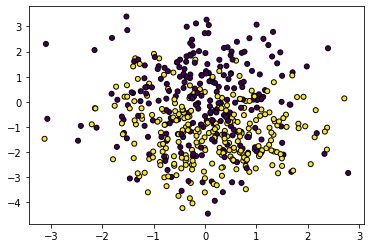

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#generate quite a lot of noise
#with only 4 informative features out of 10
#with 2 redundant features, overlapping with that 4 informative features
#and 4 noisy features
#Also, make std wider using n_clusters=2
X, y = make_classification(n_samples=500, n_features=10, n_redundant=2, n_informative=4,
                             n_clusters_per_class=2, random_state=14)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

#look at the data...it is likely not linearly separable!

#### 1.2 Feature scale your data to reach faster convergence

In [2]:
#feature scaling helps improve reach convergence faster
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### 1.3 Train test split your data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### 2. Calculate the mean and std for each feature for each class

In [4]:
def mean_var(X_train, y_train):
    n = X_train.shape[1]
    mean = np.zeros((2, n))
    std = np.zeros((2, n))
    for label in [0, 1]:
        mean[label, :] = X_train[y_train==label].mean(axis=0)
        std[label, :] = X_train[y_train==label].std(axis=0)
    return mean, std

mean, std = mean_var(X_train, y_train)
assert mean.shape == (2, X_train.shape[1])
assert std.shape == (2, X_train.shape[1])

#### 3. Define the probability density function so we can later calculate $p(x \mid y)$

In [5]:
#scipy.stats.multivariate_normal is a library with this .pdf function
#but I just code from scratch for you to see
def gaussian_pdf(X, mean, std):
    left = 1/(np.sqrt(2*np.pi)*std)
    e = (X-mean)**2 / (2* (std **2))
    right = np.exp(-e)
    return left*right

#### 3. Calculate the likelihood by calculating the probability density of each class $p(x \mid y)$

In [6]:
#guassian pdf for class 0 and 1
#Note that I am using X_test, since p(x|y) is looking at "new" evidence
likelihood0 = gaussian_pdf(X_test, mean[0, :], std[0, :])
likelihood1 = gaussian_pdf(X_test, mean[1, :], std[0, :])

#pdf should have probability of each sample for each feature
assert likelihood0.shape == (X_test.shape[0], X_test.shape[1]), "Shape is wrong for pdf0!"
assert likelihood1.shape == (X_test.shape[0], X_test.shape[1]), "Shape is wrong for pdf1!"

#### 3.1 Calculate thetotal likelihood by calculating the product of $p(x \mid y) = \prod_{i=1}^n p(x = i \mid y)$

In [7]:
#np.product
# P(feature1|class0) * P(feature2|class0)
total_likelihood0 = np.prod(likelihood0, axis=1)

# P(feature1|class1) * P(feature2|class1)
total_likelihood1 = np.prod(likelihood1, axis=1)

#### 4. Calculate the prior $p(y)$

In [8]:
#probability for class 0 and 1
m0 = len(X_train[y_train==0])
m1 = len(X_train[y_train==1])
prior0 = m0 / (m0 + m1)
prior1 = m1 / (m0 + m1)

assert prior0 + prior1 == 1, "probability not equal 1"

#### 5. Calculate the posterior $p(x \mid y)p(y)$ for each class

In [9]:
#P(class0) * P(feature1|class0) * P(feature2|class0)
posterior0 = prior0 * total_likelihood0    
#P(class1) * P(feature1|class1) * P(feature2|class1)
posterior1 = prior1 * total_likelihood1

#### 6. Calculate accuracy

In [10]:
#if probability of class 1 is more than 0, then True
yhat = 1 * posterior1 > posterior0
    

from sklearn.metrics import average_precision_score, classification_report
print("APS: ", average_precision_score(y_test, yhat))
print("Report: ", classification_report(y_test, yhat))

APS:  0.7528594432942259
Report:                precision    recall  f1-score   support

           0       0.82      0.88      0.85        81
           1       0.84      0.77      0.80        69

    accuracy                           0.83       150
   macro avg       0.83      0.82      0.82       150
weighted avg       0.83      0.83      0.83       150



### Algorithm 2: Multinomial Naive Gaussian Classification

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.  Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.  **The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.**

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

One place where multinomial naive Bayes is often used is in **text classification**, where the features $w$ are related to word counts or frequencies within the documents to be classified and $y$ will be our class.  The formation is as follows:

$$
P(y|w) = \frac{P(w|y)P(y)}{P(w)}
$$

Before we proceed, let's define some notations: $d$ stands for number of documents, $v$ stands for number of words

Steps are the followings:
    
1. Prepare your data
    - add intercept
    - X and y in the right shape
        - X (m, n)
        - y (m,  )
        - Note that theta is not needed.  Why?
    - train-test split
    - feature scale
    - clean out any missing data
    - (optional) feature engineering
    
2. Calculate the **likelihoods** of each word in the training document.  Following multinomial distribution, for a given word $w_i$, we count how many of $w_i$ belong in class $k$, we then divide this by ALL the words that belong to $k$. This gives us a probability for a word $w$ given $k$:

    $$ P(w_i \mid y=k) = \frac{count(w_i, k)}{\Sigma_{i=1}^{V} count(w_i, k)} $$
    
3. We can perform **Laplace smoothing** to account for any words with zero count
    $$ P(w_i \mid y=k) = \frac{count(w_i, k) + 1}{\Sigma_{i=1}^{V} count(w_i, k) + V} $$

4. Since we may have more than one features, we need to make a product of all features
    $$P(w \mid y=k) = \prod_{i=1}^{pos} p(w_i \mid y=k)$$
    Note that $pos$ indicates the index of each word in the test document
    
5. Find **priors** P(y) where is simply number of documents belonging to that class divided by all documents

$$P(y = k) = \frac{\Sigma_{i=1}^{d}1(y=k)}{d} $$

6. Multiply $P(y)P(w \mid y)$ for each class which will give us $p(y \mid x)$ (**posteriors**)

$$P(y=k)P(w \mid y=k)$$ or

$$P(y=k)\prod_{i=1}^{pos} p(w_i \mid y=k)$$

7. Instead of probabilities, we gonna use log probabiities which have several benefits:
    - **Speed** - Log probabilities become addition, which is faster than multiplication
    - **Stability** - Probabilities can be too small where some significant digits can be lost during calculations. Log probabiities can prevent such underflow.
    - **Simplicity** - Many distributions have exponential form.  Taking log completely takes away the exp.
    
   Now that you are convinced, 
   
   $$P(y=k)\prod_{i=1}^{pos} p(w_i \mid y=k)$$  becomes
   
  $$log P(y=k) + \Sigma_{i=1}^{pos} p(w_i \mid y=k)$$

8. Now, you will have $k$ number of posteriors for the test document.  Simply take the biggest one or <code>argmax</code>. Note that we can ignore $P(x)$ since they can be canceled on both sides.

#### 1. Prepare some data

In [11]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

print(train.data[0][:300]) #first 300 words
print("Target: ", train.target[0])  #start with 1, soc.religion.christian

From: jono@mac-ak-24.rtsg.mot.com (Jon Ogden)
Subject: Re: Losing your temper is not a Christian trait
Organization: Motorola LPA Development
Lines: 26

In article <Apr.23.02.55.47.1993.3138@geneva.rutgers.edu>, jcj@tellabs.com
(jcj) wrote:

> I'd like to remind people of the withering of the fig tr
Target:  2


#### CountVectorizer

Here we use CountVectorizer which simply counts the number of words and create column features accordingly

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print("Feature names: ", vectorizer.get_feature_names())
print("Type: ", type(X))
print(X.toarray())

vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names())

Feature names:  ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
Type:  <class 'scipy.sparse.csr.csr_matrix'>
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this', 'document is', 'first document', 'is the', 'is this', 'second document', 'the first', 'the second', 'the third', 'third one', 'this document', 'this is', 'this the']


#### 1.1 Transform our data to features of words

In [13]:
#transform our X to vectorized data
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train.data)
X_test = vectorizer.transform(test.data)
X_test = X_test.toarray()  #vectorizer gives us a sparse matrix

y_train = train.target
y_test = test.target

#### 2 to 5:Calculating likelihood anrd prior

In [14]:
def likelihood(X_class, laplace=1):
    return ((X_class.sum(axis=0)) + laplace) / (np.sum(X_class.sum(axis=0) + laplace))

In [15]:
def prior(X_class, m):
    return X_class.shape[0] / m

In [16]:
def fit(X_train, y_train):
    m, n = X_train.shape
    classes = np.unique(y_train)  #list of class
    k = len(classes) #number of class
    
    priors = np.zeros(k) #prior for each classes
    likelihoods = np.zeros((k, n)) #likehood for each class of each feature
    
    for idx, label in enumerate(classes):
        X_train_c = X_train[y_train==label]
        priors[idx] = prior(X_train_c, m)
        likelihoods[idx, :] = likelihood(X_train_c)
    return priors, likelihoods

#### 7. Log probabilities (I just skip 6)

In [17]:
def likelihood_test(likelihood, x_test):
    return np.log(likelihood) * x_test

def _predict(x_test, priors, likelihoods, classes):
    x_test = np.array(x_test)

    # Calculate posterior for each class
    posteriors = []
    for idx, c in enumerate(classes):
        prior_c = np.log(priors[idx])
        likelihoods_c = likelihood_test(likelihoods[idx,:], x_test)
        posteriors_c = np.sum(likelihoods_c) + prior_c
        posteriors.append(posteriors_c)
    return classes[np.argmax(posteriors)]

def predict(X_test, priors, likelihoods, classes):
    return [_predict(x_test, priors, likelihoods, classes) for x_test in X_test]

#### 8. Let's use them

In [18]:
priors, likelihoods = fit(X_train, y_train)

In [19]:
print(priors.shape)
print(likelihoods.shape)

(4,)
(4, 35329)


In [20]:
classes = np.unique(y_test)
print(X_test.shape)
yhat = predict(X_test, priors, likelihoods, classes)

(1432, 35329)


In [21]:
print(np.sum(yhat == y_test)/len(y_test))

0.9168994413407822
